# This is the Notebook for SWAE on the MNIST Dataset

This notebook implements Sliced Wasserstein Auto-Encoders (SWAE).

To run this notebook you'll require the following packages:

* Numpy
* Matplotlib
* tensorflow
* Keras
* h5py


In [1]:
import numpy as np
import keras.utils
from keras.layers import Input,Dense, Flatten
from keras.models import load_model, Model
from keras.layers import Conv2D, UpSampling2D, AveragePooling2D
from keras.layers import LeakyReLU,Reshape
from keras.datasets import mnist
from keras.models import save_model
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
import time

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Define three helper functions
 * generateTheta(L,dim) -> Generates $L$ random sampels from $\mathbb{S}^{dim-1}$
 * generateZ(batchsize,endim) -> Generates 'batchsize' samples 'endim' dimensional samples from $q_Z$ 
 * stitchImages(I,axis=0) -> Helps us with visualization

In [2]:
def generateTheta(L,endim):
    # This function generates L random samples from the unit `ndim'-u
    theta=[w/np.sqrt((w**2).sum()) for w in np.random.normal(size=(L,endim))]
    return np.asarray(theta)
def generateZ(batchsize,endim):
    # This function generates samples from a uniform distribution in 
    # the `endim'-dimensional space
    z=2*(np.random.uniform(size=(batchsize,endim))-0.5)
    return z
def stitchImages(I,axis=0):
    n,N,M,K=I.shape
    if axis==0:
        img=np.zeros((N*n,M,K))
        for i in range(n):
            img[i*N:(i+1)*N,:,:]=I[i,:,:,:]
    else:
        img=np.zeros((N,M*n,K))
        for i in range(n):
            img[:,i*M:(i+1)*M,:]=I[i,:,:,:]
    return img

## Defining the Encoder/Decoder as Keras graphs

In this section we define our encoder-decoder architectures and the corresponding loss function for the SWAE. 

In [3]:
img=Input((28,28,1)) #Input image 
interdim=128 # This is the dimension of intermediate latent variable 
             #(after convolution and before embedding)
endim=2 # Dimension of the embedding space
embedd=Input((endim,)) #Keras input to Decoder
depth=16 # This is a design parameter and in fact it is not the depth!
L=50 # Number of random projections
batchsize=500 

### Define Encoder

In [4]:

x=Conv2D(depth*1, (3, 3), padding='same')(img)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Conv2D(depth*1, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=AveragePooling2D((2, 2), padding='same')(x)
x=Conv2D(depth*2, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Conv2D(depth*2, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=AveragePooling2D((2, 2), padding='same')(x)
x=Conv2D(depth*4, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Conv2D(depth*4, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=AveragePooling2D((2, 2), padding='same')(x)
x=Flatten()(x)
x=Dense(interdim,activation='relu')(x)
encoded=Dense(endim)(x)

encoder=Model(inputs=[img],outputs=[encoded])
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 16)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        4640      
__________

### Define Decoder

In [5]:
x=Dense(interdim)(embedd)
x=Dense(depth*64,activation='relu')(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Reshape((4,4,4*depth))(x)
x=UpSampling2D((2, 2))(x)
x=Conv2D(depth*4, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Conv2D(depth*4, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
x=UpSampling2D((2, 2))(x)
x=Conv2D(depth*4, (3, 3), padding='valid')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Conv2D(depth*4, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
x=UpSampling2D((2, 2))(x)
x=Conv2D(depth*2, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
x=Conv2D(depth*2, (3, 3), padding='same')(x)
x=LeakyReLU(alpha=0.2)(x)
# x=BatchNormalization(momentum=0.8)(x)
# x=BatchNormalization(momentum=0.8)(x)
decoded=Conv2D(1, (3, 3), padding='same',activation='sigmoid')(x)

decoder=Model(inputs=[embedd],outputs=[decoded])
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              132096    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 64)          0         
__________

Here we define Keras variables for $\theta$ and sample $z$s.

In [6]:
theta=K.variable(generateTheta(L,endim)) #Define a Keras Variable for \theta_ls
z=K.variable(generateZ(batchsize,endim)) #Define a Keras Variable for samples of z

Put encoder and decoder together to get the autoencoder

In [7]:
# Generate the autoencoder by combining encoder and decoder
aencoded=encoder(img)
ae=decoder(aencoded)
autoencoder=Model(inputs=[img],outputs=[ae])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 203250    
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         308193    
Total params: 511,443
Trainable params: 511,443
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Let projae be the projection of the encoded samples
projae=K.dot(aencoded,K.transpose(theta))
# Let projz be the projection of the $q_Z$ samples
projz=K.dot(z,K.transpose(theta))
# Calculate the Sliced Wasserstein distance by sorting 
# the projections and calculating the L2 distance between
W2=(tf.nn.top_k(tf.transpose(projae),k=batchsize).values-
    tf.nn.top_k(tf.transpose(projz),k=batchsize).values)**2

In [9]:
w2weight=K.variable(10.0)
crossEntropyLoss= (1.0)*K.mean(K.binary_crossentropy(K.flatten(img),K.flatten(ae)))
L1Loss= (1.0)*K.mean(K.abs(K.flatten(img)-K.flatten(ae)))
W2Loss= w2weight*K.mean(W2)
# I have a combination of L1 and Cross-Entropy loss for the first term and then 
# W2 for the second term
vae_Loss=L1Loss+crossEntropyLoss+W2Loss
autoencoder.add_loss(vae_Loss) # Add the custom loss to the model

In [10]:
#Compile the model
autoencoder.compile(optimizer='rmsprop',loss='')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Output "model_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "model_2" during training.
  


### Load the MNIST dataset

In [11]:
(x_train,y_train),(x_test,_)=mnist.load_data()
x_train=np.expand_dims(x_train.astype('float32')/255.,3)

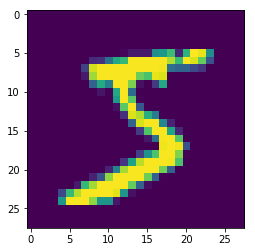

In [12]:
plt.imshow(np.squeeze(x_train[0,...]))
plt.show()

## Optimize the Loss

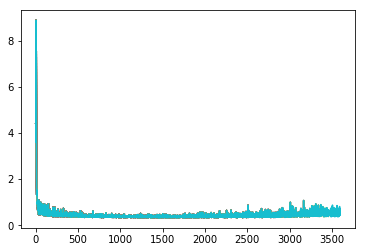

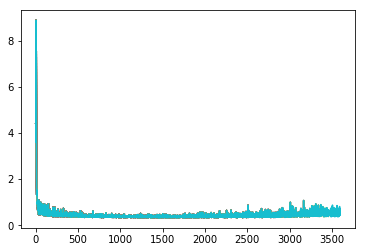

In [13]:
loss=[]
fig1=plt.figure()
for epoch in range(30):
    ind=np.random.permutation(x_train.shape[0])    
    if epoch>10:
        K.set_value(w2weight,1.1*K.eval(w2weight))
    for i in range(int(x_train.shape[0]/batchsize)):
        Xtr=x_train[ind[i*batchsize:(i+1)*batchsize],...]
        theta_=generateTheta(L,endim)
        z_=generateZ(batchsize,endim)
        K.set_value(z,z_)
        K.set_value(theta,theta_)        
        loss.append(autoencoder.train_on_batch(x=Xtr,y=None))        
    plt.plot(np.asarray(loss))
    display.clear_output(wait=True)
    display.display(plt.gcf()) 
    time.sleep(1e-3) 

## Encode and decode x_train

In [14]:
# Test autoencoder
en=encoder.predict(x_train)# Encode the images
dec=decoder.predict(en) # Decode the encodings

## Visualize the encoding space

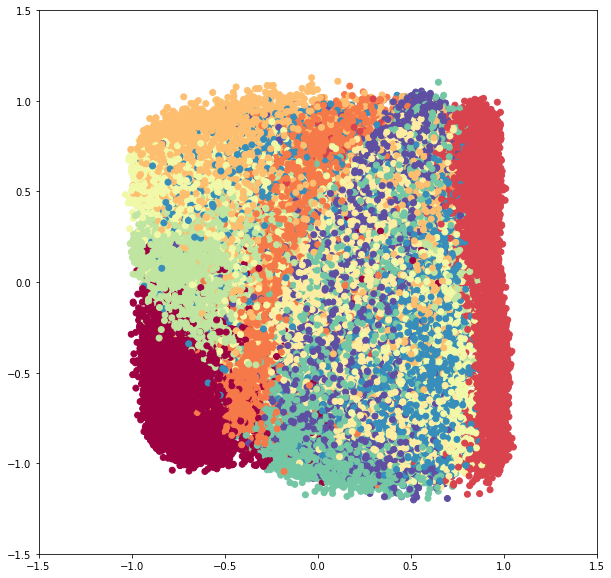

In [15]:
# Distribution of the encoded samples
plt.figure(figsize=(10,10))
plt.scatter(en[:,0],-en[:,1],c=10*y_train, cmap=plt.cm.Spectral)
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.show()

### Sample a grid in the encoding space and decode it to visualize this space

In [16]:
#Sample the latent variable on a Nsample x Nsample grid
Nsample=25
hiddenv=np.meshgrid(np.linspace(-1,1,Nsample),np.linspace(-1,1,Nsample))
v=np.concatenate((np.expand_dims(hiddenv[0].flatten(),1),
                  np.expand_dims(hiddenv[1].flatten(),1)),1)
# Decode the grid
decodeimg=np.squeeze(decoder.predict(v))

In [17]:
#Visualize the grid 
count=0
img=np.zeros((Nsample*28,Nsample*28))
for i in range(Nsample):
    for j in range(Nsample):        
        img[i*28:(i+1)*28,j*28:(j+1)*28]=decodeimg[count,...]
        count+=1

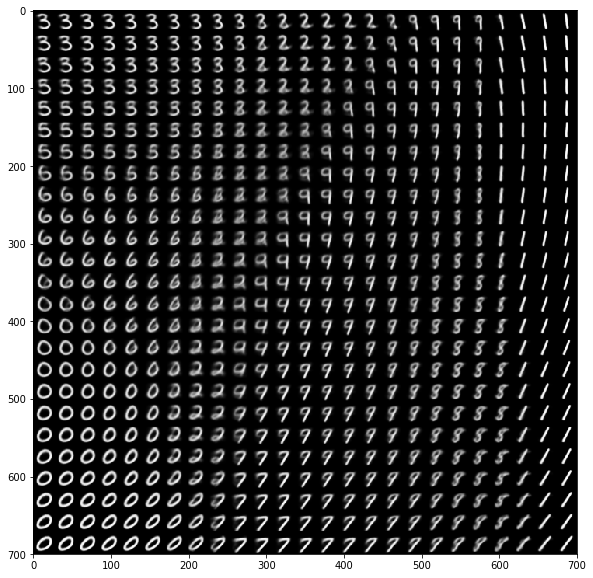

In [35]:
fig=plt.figure(figsize=(10,10))
plt.imshow(img,cmap='gray')
plt.show()

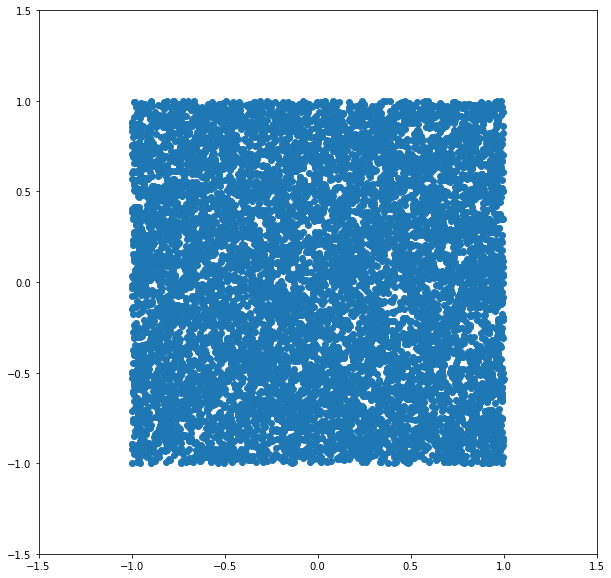

In [19]:
#Visualize the z samples
plt.figure(figsize=(10,10))
Z=generateZ(10000,2)
plt.scatter(Z[:,0],Z[:,1])
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.show()

### Save the trained models! 

In [20]:
save_model(encoder,filepath='MNIST_uniform_encoder.h5')
save_model(decoder,filepath='MNIST_uniform_decoder.h5')
save_model(autoencoder,filepath='MNIST_uniform_autoencoder.h5')

## Generate random samples with respect to $q_Z$.

In [36]:
randomSamples=generateZ(Nsample**2,2)
randomdecodeimg=np.squeeze(decoder.predict(randomSamples))

In [37]:
imgRandom=np.zeros((Nsample*28,Nsample*28))
count=0
for i in range(Nsample):
    for j in range(Nsample):        
        imgRandom[i*28:(i+1)*28,j*28:(j+1)*28]=randomdecodeimg[count,...]
        count+=1

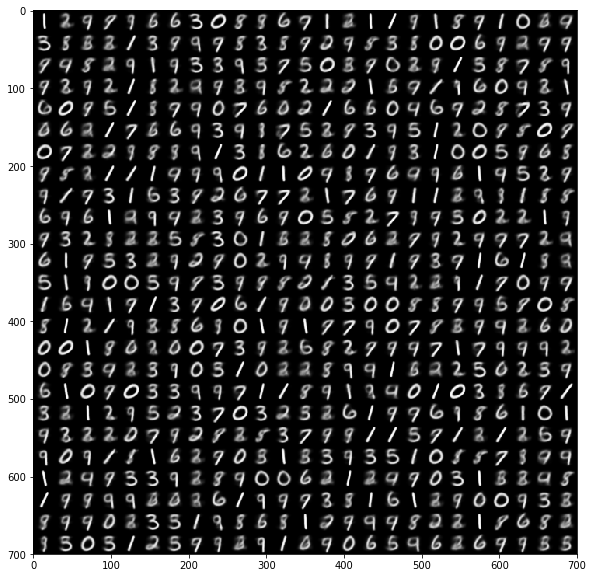

In [38]:
fig=plt.figure(figsize=(10,10))
plt.imshow(imgRandom,cmap='gray')
plt.show()